### Agentic Cnditional RAG with custom data

In [1]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph , END
from langchain_groq import ChatGroq
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pinecone.grpc import PineconeGRPC as Pinecone
from sentence_transformers import SentenceTransformer
from langchain_core.documents import Document

c:\Users\Himanshu\Desktop\GenAi-Project\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
llm = ChatGroq(groq_api_key= os.getenv("NEW_GROQ_API_KEY") , model_name="llama-3.1-8b-instant",temperature=0.1,max_tokens=1024)
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000021F96EBF8C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021F963A2DB0>, model_name='llama-3.1-8b-instant', temperature=0.1, model_kwargs={}, groq_api_key=SecretStr('**********'), max_tokens=1024)

### State Definition

In [4]:
class AgentState(TypedDict):
    question : str
    documents : List[str]
    ans : str
    needs_retrieval : bool

In [5]:
# Agentic Function

In [5]:
def decide_retrieval(state: AgentState) -> AgentState:
    question = state["question"]
    prompt = f"""
You are an AI controller in a Retrieval-Augmented Generation (RAG) system.

Task:
Decide whether external knowledge retrieval is REQUIRED to answer the user query correctly and confidently.

Rules:
- Choose RETRIEVE if the query:
  - Refers to specific documents, standards, datasets, or user-provided files
  - Requires precise, technical, or domain-specific information
  - Cannot be answered confidently without external sources
- Choose GENERATE if the query:
  - Is conversational or opinion-based
  - Can be answered accurately using general knowledge alone

Important:
- If you are uncertain, choose RETRIEVE.

User Query:
"{question}"

Respond with ONLY one word:
RETRIEVE or GENERATE

"""
    response = llm.invoke(prompt)
    decision = response.content.strip().upper()
    if decision not in {"RETRIEVE","GENERATE"}:
        decision = "RETRIEVE"
    needs_retrieval = decision == "RETRIEVE"
    return {**state, "needs_retrieval": needs_retrieval}

In [6]:
# If needs_retrieval is TRUE:
def retrieve_document(state: AgentState) -> AgentState:
    question = state["question"]
    #Pinecone configuration
    pinecone_api_key = os.getenv("PINECONE_API_KEY")
    pinecone_env = os.getenv("PINECONE_ENVIRONMENT")
    pc = Pinecone(api_key=pinecone_api_key)
    index_name = "ilibrary-backend-documentation-rag"

    host = os.getenv("PINECONE_HOST")
    index = pc.Index(host=host)

    model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
    query_embedding = model.encode(question).tolist()
    matching_result = index.query(
        vector=query_embedding,
        top_k=5,
        namespace="rag-docs",
        include_metadata=True
    )
    context = []
    for doc in matching_result.matches:
        context.append(doc.metadata['text'])
    if not context:
        return "No relevent docs found in vectorDB."
    
    return {**state,"documents":context}

In [7]:
def generate_ans(state: AgentState) -> AgentState:
    """
    Generate an answer using the retrieved documents or direct response
    """
    print("STATE KEYS:", state.keys())
    question = state["question"]
    context = state["documents"]

    if context:
        prompt = f"""Based on the following context, answer the question:

Context:
{context}

Question: {question}

Answer:"""
    else:
        prompt = f"Answer the following question: {question}"
    
    response = llm.invoke(prompt)
    answer = response.content
    return {**state, "ans": answer}

In [8]:
def should_retrieve(state: AgentState)-> str:
    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

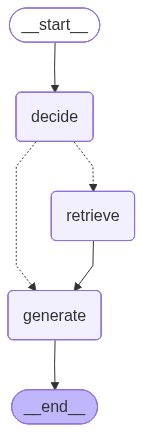

In [9]:
workflow = StateGraph(AgentState)

workflow.add_node("decide",decide_retrieval)
workflow.add_node("retrieve",retrieve_document)
workflow.add_node("generate",generate_ans)

workflow.set_entry_point("decide")

workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)

workflow.add_edge("retrieve","generate")
workflow.add_edge("generate",END)

app = workflow.compile()
app

In [10]:
def ask_question(question: str):
    initial_state = {
        "question": question,
        "documents": [],
        "ans": "",
        "needs_retrieval": False
    }
    result = app.invoke(initial_state)
    return result

In [11]:
result = ask_question("How many entities are there in this project?")
print(result['ans'])
print(result['needs_retrieval'])

STATE KEYS: dict_keys(['question', 'documents', 'ans', 'needs_retrieval'])
Based on the provided context, the entities mentioned are:

1. User
2. Seat
3. Booking
4. Subscription
5. Payment

There are 5 entities in this project.
True


In [12]:
result = ask_question("What is the role of user class?")
print(result['ans'])
print(result['needs_retrieval'])

STATE KEYS: dict_keys(['question', 'documents', 'ans', 'needs_retrieval'])
The role of the User class is to represent a user in the database. It is a JPA entity class that mirrors the schema in the ER-Diagram and contains fields such as name and email, which are considered Personally Identifiable Information (PII). The User class is used in the User Registration process, where it is validated, hashed, and saved to the database. It is also used in the User Login process, where it is loaded from the database and compared with the provided credentials.
True


In [13]:
result = ask_question("Explain how spring security implement in this project in detail?")
print(result['ans'])
print(result['needs_retrieval'])

STATE KEYS: dict_keys(['question', 'documents', 'ans', 'needs_retrieval'])
Spring Security is tightly integrated into this project, providing robust security features to protect the application from various threats. Here's a detailed explanation of how Spring Security is implemented in this project:

**1. Configuration**

The security configuration is defined in a class like `SecurityConfig`, which extends `WebSecurityConfigurerAdapter`. This class is responsible for defining the security rules, such as which parts of the API are public and which are protected.

**2. Security Rules**

The security rules are defined using the `antMatchers` method, which specifies the URLs that are allowed or denied access. For example:

```java
.antMatchers("/public/**").permitAll()
.anyRequest().authenticated()
```

This rule allows all requests to the `/public` endpoint to be accessed without authentication, while all other requests require authentication.

**3. Authentication**

The authentication pr

In [14]:
result = ask_question("Explain the workflow of this project?")
print(result['ans'])
print(result['needs_retrieval'])

STATE KEYS: dict_keys(['question', 'documents', 'ans', 'needs_retrieval'])
The workflow of this project, 'iLibrary-Backend', is a 3-tier monolithic architecture that follows a client-server interaction. Here's a step-by-step explanation of the workflow:

1. **Client Request**: The client, which can be a web or mobile frontend, sends an HTTP(S) request to the Spring Boot API server.

2. **Spring Boot API Server**: The Spring Boot API server receives the request and handles the business logic. It interacts with the underlying databases and external services.

3. **Business Logic**: The business logic is handled by the Services layer, which contains the rules and validation for the application. For example, it checks if a user can book a seat if their subscription has expired.

4. **Database Interaction**: The Services layer interacts with the Repositories layer, which talks to the MySQL database to save and retrieve data.

5. **Response**: The Spring Boot API server processes the request

In [20]:
result = ask_question("How Data flow is managed in this project?")
print(result['ans'])
print(result['needs_retrieval'])

Based on the provided context, the data flow in this project is managed as follows:

1. **Client Request**: The client sends a request to the server, typically in the form of a POST or GET request.
2. **Controller**: The request is received by a controller (e.g., `BookingController`) which is responsible for handling the request and delegating the actual work to the service layer.
3. **Service Layer**: The controller calls a method on a service class (e.g., `BookingService`) which performs the actual business logic. This layer is responsible for implementing complex business rules.
4. **Data Access Layer**: The service layer interacts with the data access layer (e.g., `Repository` interfaces) to perform CRUD operations and custom queries on the database.
5. **Database**: The data access layer interacts with the database (e.g., MySQL) to persist and retrieve data.
6. **External Integrations**: The system integrates with external services (e.g., email service) to send notifications and p

In [58]:
result = ask_question("Thank you.")
print(result['ans'])
print(result['needs_retrieval'])

STATE KEYS: dict_keys(['question', 'documents', 'ans', 'needs_retrieval'])
You're welcome.
False


In [15]:
result = ask_question("Explain the database schema used in the application")
print(result['ans'])

STATE KEYS: dict_keys(['question', 'documents', 'ans', 'needs_retrieval'])
The database schema used in the application is a relational model that balances normalization with query performance. It consists of three main tables:

1. **`users` table**: This table stores user information, including:
   - `id`: a unique identifier for each user
   - `name`: the user's name
   - `email`: the user's email address, which has a UNIQUE constraint to prevent duplicate accounts
   - `password_hash`: a bcrypt hash of the user's password (not plaintext)
   - `roles`: the user's authorization level

2. **`seat` table**: This table represents the physical inventory of seats, including:
   - `seat_number`: a business identifier for each seat
   - `status`: the status of the seat, which can be `AVAILABLE`, `BOOKED`, or `OCCUPIED`

3. **`subscription` table**: This table tracks a user's membership, including:
   - `user_id`: a foreign key referencing the `id` column in the `users` table
   - `status`: th

In [16]:
result = ask_question("Which services interact with the user module?")
print(result['ans'])

STATE KEYS: dict_keys(['question', 'documents', 'ans', 'needs_retrieval'])
Based on the provided context, the following services interact with the user module:

1. `UserService`: This service is directly related to the user module, as it handles user entity operations.
2. `JwtService`: Although primarily focused on JWT creation and validation, it may interact with the user module to handle authentication and authorization.
3. `UserInfoService`: This service is specifically mentioned as a security-specific service that integrates with Spring Security to load user data, indicating its interaction with the user module.

These services are part of the `com.ilibrary.service` package, which contains classes with business logic related to the user module.


In [17]:
result = ask_question("What authentication mechanism is implemented?")
print(result['ans'])

STATE KEYS: dict_keys(['question', 'documents', 'ans', 'needs_retrieval'])
The authentication mechanism implemented is a combination of the following:

1. **Username-Password Authentication**: This is used for the login request (`POST /auth/login`) where the user sends their email and password. The provided password is compared with the stored hash using BCrypt.
2. **JSON Web Token (JWT) Authentication**: After successful authentication, a JWT token is generated and returned to the client. This token is then sent in the `Authorization: Bearer <token>` header for subsequent requests to access protected endpoints.

The JWT token is validated on each incoming request by checking its signature, expiration time, and well-formedness. If valid, the token is used to extract the user's identity and set it in the `SecurityContextHolder`, making the user's details available for the rest of the request lifecycle.

Additionally, the system implements **Role-Based Access Control (RBAC)** using Sprin